In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from datasets import Dataset, load_from_disk
import torch.nn.functional as F

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 256

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [4]:
df = load_from_disk("./data/encoded34", keep_in_memory=False)

In [5]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n, m, p, b):
        super().__init__()
        self.e1 = torch.nn.Linear(n, m)
        self.e2 = torch.nn.Linear(m, p)
        self.e3 = torch.nn.Linear(p, b)
        self.dec3 = torch.nn.Linear(b, p)
        self.dec2 = torch.nn.Linear(p, m)
        self.dec1 = torch.nn.Linear(m, n)
        
    def forward(self, x):
        x = self.e1(x)
        x = self.e2(F.relu(x))
        encoded = self.e3(F.relu(x))
        x = self.dec3(encoded)
        x = self.dec2(F.relu(x))
        x = self.dec1(F.relu(x))
        return x

In [6]:
df_train = df['train']
df_test = df['test']
dataloader_train = DataLoader(df_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dataloader_test = DataLoader(df_test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [7]:
ts = next(iter(dataloader_train))
ts

{'data': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9525, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0925],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3102, 0.0287],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])}

In [8]:
ts['data'].size()

torch.Size([256, 512])

In [9]:
def training_loop(model, dataloader_train, dataloader_test, nf):
    best_vloss = 1e+10
    # bs = dataloader_train.batch_size
    bntr, bntst = len(dataloader_train), len(dataloader_test)

    learning_rate = 1e-2
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss(reduction='mean')
    n_epoch = 1000

    for epoch in range(1, n_epoch+1):
        model.train()
        loss_train = 0.0
        for itms in dataloader_train:
            x=itms['data']
            batch_size = x.shape[0]
            x = x.to(device)
            # lables = lables.to(device)
            outputs = model(x)
            loss = loss_fn(outputs, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        model.eval()
        loss_val = 0.0

        with torch.no_grad():
            for itms in dataloader_test:
                x=itms['data']
                x = x.to(device)
                outputs = model(x)
                loss_v = loss_fn(outputs, x)
                loss_val += loss_v.item()
        #     
            if loss_val < best_vloss:
                torch.save(model.state_dict(), nf)
                best_vloss = loss_val


    
        if epoch == 1 or epoch%100 == 0:
            print(f'Epoch: {epoch}, Epoch train loss: {loss_train/bntr}')
            print(f'Epoch val loss: {loss_val/bntst}')
            # print(f'Accuracy: {correct/total*100}')
            
    return best_vloss

In [61]:
# del model_auto
model_auto = AutoEncoder(512, 256, 128, 64).to(device)

In [62]:
training_loop(model_auto, dataloader_train, dataloader_test, nf='best_model_autoenc64_resnet34.pt')

Epoch: 1, Epoch train loss: 0.061544549149962574
Epoch val loss: 0.047927623614668846
Epoch: 100, Epoch train loss: 0.003291256672057968
Epoch val loss: 0.003711095079779625
Epoch: 200, Epoch train loss: 0.0030910355003120806
Epoch val loss: 0.003553428570739925
Epoch: 300, Epoch train loss: 0.002949525136500597
Epoch val loss: 0.0035514419432729483
Epoch: 400, Epoch train loss: 0.002797845115240377
Epoch val loss: 0.0033965249313041568
Epoch: 500, Epoch train loss: 0.0027985457205571807
Epoch val loss: 0.00343519973102957
Epoch: 600, Epoch train loss: 0.002800550043153075
Epoch val loss: 0.0033792966278269887
Epoch: 700, Epoch train loss: 0.0027816602691578176
Epoch val loss: 0.003466544672846794
Epoch: 800, Epoch train loss: 0.0027022978846127023
Epoch val loss: 0.0032653278904035687
Epoch: 900, Epoch train loss: 0.0027251232218427155
Epoch val loss: 0.003361801151186228
Epoch: 1000, Epoch train loss: 0.00272820233546484
Epoch val loss: 0.0034850884694606066


0.006191310938447714

In [63]:
model_auto.load_state_dict(torch.load('best_model_autoenc64_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [64]:
loss_fn = torch.nn.MSELoss(reduction='none')
torch.mean(loss_fn(model_auto(ts['data'].to(device)), ts['data'].to(device)), dim=1).size()

torch.Size([256])

In [10]:
def extract_error(model, dataloader_train, dataloader_test):
    loss_fn = torch.nn.MSELoss(reduction='none')
    errors = []
    model.eval()
    with torch.no_grad():
        for itms in dataloader_train:
            x=itms['data']
            batch_size = x.shape[0]
            x = x.to(device)
            # lables = lables.to(device)
            outputs = model(x)
            error = torch.mean(loss_fn(outputs, x), dim=1).cpu().tolist()
            errors.extend(error)

            # 
        for itms in dataloader_test:
            x=itms['data']
            x = x.to(device)
            outputs = model(x)
            error = torch.mean(loss_fn(outputs, x), dim=1).cpu().tolist()
            errors.extend(error)

            
    return errors

In [66]:
errors = extract_error(model_auto, dataloader_train, dataloader_test)
len(errors)

7168

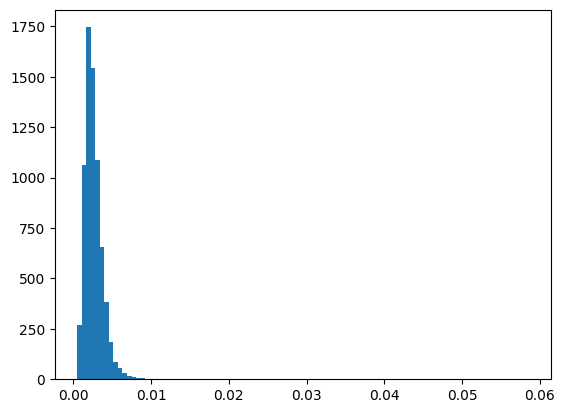

In [67]:
plt.hist(errors, bins=100)
plt.show()

In [68]:
np.mean(errors), np.std(errors)

(np.float64(0.0026712339925925982), np.float64(0.0014092655805875568))

In [11]:
model_auto = AutoEncoder(512, 256, 128, 32).to(device)

In [12]:
training_loop(model_auto, dataloader_train, dataloader_test, nf='best_model_autoenc32_resnet34.pt')

Epoch: 1, Epoch train loss: 0.061213803549225516
Epoch val loss: 0.046882232651114464
Epoch: 100, Epoch train loss: 0.003544569705039836
Epoch val loss: 0.0037184030516073108
Epoch: 200, Epoch train loss: 0.0032904219473353946
Epoch val loss: 0.0036454818909987807
Epoch: 300, Epoch train loss: 0.003088012382459755
Epoch val loss: 0.0035507328575477004
Epoch: 400, Epoch train loss: 0.0032021491430126703
Epoch val loss: 0.0038935852935537696
Epoch: 500, Epoch train loss: 0.003023611193594451
Epoch val loss: 0.003589494852349162
Epoch: 600, Epoch train loss: 0.003061410827705493
Epoch val loss: 0.0036142512690275908
Epoch: 700, Epoch train loss: 0.0030208864392569433
Epoch val loss: 0.003408308606594801
Epoch: 800, Epoch train loss: 0.0030568022585402313
Epoch val loss: 0.003545186249539256
Epoch: 900, Epoch train loss: 0.002972554084128485
Epoch val loss: 0.0035160199040547013
Epoch: 1000, Epoch train loss: 0.0029808163123491863
Epoch val loss: 0.003705167444422841


0.006448032101616263

In [14]:
model_auto.load_state_dict(torch.load('best_model_autoenc32_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [15]:
errors = extract_error(model_auto, dataloader_train, dataloader_test)
len(errors)

7168

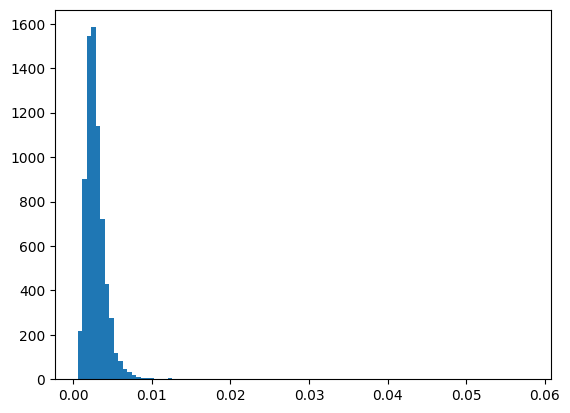

In [16]:
plt.hist(errors, bins=100)
plt.show()

In [17]:
np.mean(errors), np.std(errors)

(np.float64(0.0028689661610152534), np.float64(0.0015227751630189164))

In [11]:
model_auto = AutoEncoder(512, 256, 128, 16).to(device)

In [12]:
training_loop(model_auto, dataloader_train, dataloader_test, nf='best_model_autoenc16_resnet34.pt')

Epoch: 1, Epoch train loss: 0.061481214773196444
Epoch val loss: 0.04827135615050793
Epoch: 100, Epoch train loss: 0.003260822339843099
Epoch val loss: 0.0036884754663333297
Epoch: 200, Epoch train loss: 0.003042131707143898
Epoch val loss: 0.0035193634685128927
Epoch: 300, Epoch train loss: 0.0029767047739229524
Epoch val loss: 0.003585038357414305
Epoch: 400, Epoch train loss: 0.0028921490212759147
Epoch val loss: 0.0033607601653784513
Epoch: 500, Epoch train loss: 0.002865042107609602
Epoch val loss: 0.003401499125175178
Epoch: 600, Epoch train loss: 0.002895288241024201
Epoch val loss: 0.003413943573832512
Epoch: 700, Epoch train loss: 0.0028236717290173355
Epoch val loss: 0.003311182139441371
Epoch: 800, Epoch train loss: 0.0028386438319173
Epoch val loss: 0.0033355921041220427
Epoch: 900, Epoch train loss: 0.0027948921331419395
Epoch val loss: 0.003356970497407019
Epoch: 1000, Epoch train loss: 0.0027516895923047112
Epoch val loss: 0.0033365938579663634


0.006075288634747267

In [13]:
model_auto.load_state_dict(torch.load('best_model_autoenc16_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [14]:
errors = extract_error(model_auto, dataloader_train, dataloader_test)
len(errors)

7168

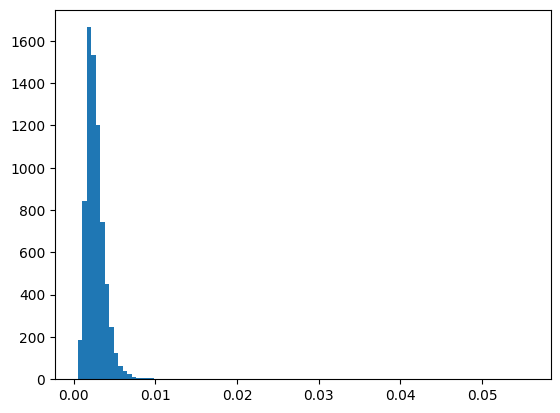

In [15]:
plt.hist(errors, bins=100)
plt.show()

In [16]:
np.mean(errors), np.std(errors)

(np.float64(0.0026551851744004906), np.float64(0.0014190136052233786))